# Prep variables for HydroTas 2020-2021 workplan:
- Skill assessment
  - rainfall, surface temp and surface wind over Australia region and Tasmania region
  - Assess skill as function of start month and ensemble size
- UNSEEN
  - Tasmanian rainfall and Melbourne surface temperature

In [1]:
import glob
import cftime
import geopandas
import regionmask
import numpy as np
import xarray as xr
from dask.distributed import Client
from dask_jobqueue import PBSCluster

In [ ]:
walltime = '02:00:00'
cores = 12
memory = '24GB'

cluster = PBSCluster(processes=1,
                     walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P ux06',
                                '-l jobfs=100GB',
                                '-l storage=gdata/xv83+gdata/v14+scratch/v14'],
                     local_directory='$PBS_JOBFS',
                     header_skip=["select"])

In [ ]:
cluster.scale(jobs=4)
client = Client(cluster)
client

# Create Australia land mask on CAFE grid

In [19]:
CAFE_grid = xr.open_dataset('data/cafe_atmos_grid_info.nc')['zsurf']

NRM = geopandas.read_file('data/NRM_clusters/NRM_clusters.shp')
regions = regionmask.Regions_cls(
    name='NRM_regions', 
    numbers=list(NRM.index), 
    names=list(NRM.label), 
    abbrevs=list(NRM.code),
    outlines=list(NRM.geometry))
regions_mask = regions.mask(CAFE_grid, lon_name='lon', lat_name='lat')

Australia_mask = xr.where(regions_mask.notnull(), True, False)

# Global parameters

In [40]:
REGIONS = {'AUS': Australia_mask,
           'TAS': (-42, 146.5),
           'MEL': (-37.81, 144.96)}

In [41]:
def get_region(ds, region, wrap_lons=True, lat_name='lat', lon_name='lon'):
    """ Return a region from a provided DataArray or Dataset
        
        Parameters
        ----------
        region: xarray DataArray or list
            The region to extract. Can be provided in three formats:
              - if DataArray, a mask with True for points to include and False elsewhere
              - if list of length 4, a region specified by latitudinal and longitudinal 
                bounds as follows [lat_min, lat_max, lon_min, lon_max]
              - if list of length 2, a point location as follows [lat, lon]. The nearest 
                grid cell is returned in this case
        wrap_lons : boolean, optional
            Wrap longitude values of da into the range between 0 and 360
    """
    if wrap_lons:
        ds = ds.assign_coords({lon_name: (ds[lon_name] + 360)  % 360})
        ds = ds.sortby(lat_name).sortby(lon_name)
        
    if isinstance(region, xr.DataArray):
        return ds.where(region, drop=True)
    elif isinstance(region, (tuple, list)):
        if len(region) == 2:
            return ds.sel({lat_name: region[0], 
                           lon_name: region[1]},
                          method='nearest')
        elif len(region) == 4:
            return ds.sel({lat_name: slice(region[0], region[1]),
                           lon_name: slice(region[2], region[3])})
    else:
        raise InputError('Unrecognised format for input region')

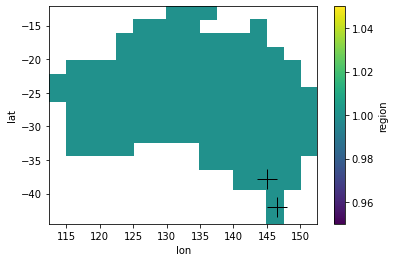

In [52]:
import matplotlib.pyplot as plt
get_region(Australia_mask, Australia_mask).plot()
plt.plot(146.5, -42, '+', color='k', markersize=20)
plt.plot(144.96, -37.81, '+', color='k', markersize=20)